# HIGGS ANALYSIS: 
### $H \to WW \to 2 \ell 2 \nu$ 
### (ggH) Production Mode


> The new updated file wrorking fine as of 16-10-2025. Refer this

---

In [28]:
from datetime import datetime                                                         # For timestamp

print(f"Last modified: {datetime.now().strftime("%d %B %Y, %H:%M")}")                 # Print last modified date and time

# Working with directories and files
import os 
# Check the current directory
print("Current directory:", os.getcwd())

# Change to the folder containing NanoAOD ROOT files
os.chdir("C:\\MAIN\\HSF-India\\MC_samples_final")
# os.chdir("C:\\MAIN\\HSF-India\\Test_samples")

# Confirm the change
print("\nNew working directory:", os.getcwd())

for file in os.listdir():
    if file.endswith(".root"):
        print(f'- {file}')

Last modified: 16 October 2025, 11:34
Current directory: C:\MAIN\HSF-India\MC_samples_final

New working directory: C:\MAIN\HSF-India\MC_samples_final
- DATA_MuonE_2016.root
- Diboson.root
- DY.root
- Higgs.root
- Single_top.root
- TTBar.root
- Wjets.root


---

### Setting up imports

In [ ]:
import uproot                          # For reading ROOT files                    
import awkward as ak                   # For handling jagged arrays
import numpy as np                     # For numerical operations
import matplotlib.pyplot as plt        # For plotting
import vector                          # For vector operations
from hist import Hist                  # For histogramming
from tqdm import tqdm                  # For progress bars
import gc                              # For garbage collection
%matplotlib inline                    
# %pip install prettytable             # Uncomment this line if PrettyTable is not installed
from prettytable import PrettyTable    # For displaying tables

# Register vector support for awkward arrays
vector.register_awkward()

### Samples collections

This

In [4]:

SAMPLES = {
    "signal": {
        "color": "#EC2424",  # Strong red
        "is_signal": True,
        "stack_order": None
    }
    # "DY_to_Tau_Tau": {
    #     "color": "#0C3AA5",  # Deep blue
    #     "is_signal": False,
    #     "stack_order": 0
    # },
    # "Wjets": {
    #     "color": "#23D9ED",  # Teal
    #     "is_signal": False,
    #     "stack_order": 1
    # },
    # "Top_antitop": {
    #     "color": "#29B829",  # Dark green
    #     "is_signal": False,
    #     "stack_order": 2
    # },
    # "Single_Top": {
    #     "color": "#B26EF1",  # Purple
    #     "is_signal": False,
    #     "stack_order": 3
    # },
    # "Diboson": {
    #     "color": "#DDB340",  # Mustard
    #     "is_signal": False,
    #     "stack_order": 4
    # },
    # "Data": {
    #     "color": "#000000",  # Black
    #     "is_signal": False,
    #     "stack_order": None
    # }
}


In [5]:
# Extract colors for backward compatibility
colors = {key: value["color"] for key, value in SAMPLES.items()}


In [6]:
# %%
# Load file names from file
files = {}
with open("files.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        key, filename = line.split(maxsplit=1)
        files[key] = filename

print("Files to process:")
for key, file in files.items():
    print(f"{key}: {file}")

Files to process:
signal: Higgs.root


---

### Helper functions


In [7]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

### Load events

In [8]:
# %%
def load_events(filename, batch_size=100_000):
    """Load events from a ROOT file in batches"""
    print(f"\nProcessing: {filename}")

    columns = [
        # Electrons
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        # Muons
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        # MET
        "MET_pt", "MET_phi",
        # Jets
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    with uproot.open(filename) as f:
        tree = f['Events']
        total_entries = tree.num_entries
        print(f"Total events: {total_entries}")

        num_batches = (total_entries + batch_size - 1) // batch_size
        
        pbar = tqdm(
            tree.iterate(columns, step_size=batch_size, library="ak"),
            total=num_batches,
            desc="Processing batches",
            unit="batch",
            ncols=100
        )
        
        for batch_num, arrays in enumerate(pbar):
            pbar.set_postfix({
                'events': f"{len(arrays):,}",
                'batch': f"{batch_num + 1}/{num_batches}"
            })
            yield arrays

### select tight leptons


In [9]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

### select e-mu events

In [10]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


### Calculate kinematic variables

In [11]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


### jet counting 

### Create $m_{jj}$

In [12]:
def calculate_mjj(jets):
    """Calculate invariant mass of the two leading jets.
    
    Assumes jets are already sorted by pT (descending).
    Returns 0 for events with < 2 jets.
    """
    # Get number of jets per event
    n_jets = ak.num(jets)
    
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

In [13]:

def count_jets(arrays, jet_pt_threshold=30, tight_leptons = None):
    """Select good jets, sort them by pt, and build jet category masks.
    Good jets: jetId >= 2 (Tight ID) AND pt > jet_pt_threshold.

    Returns
    -------
    n_jets : ak.Array
        Number of good jets per event (above pt threshold).
    good_mask : ak.Array
        Boolean mask applied on arrays.Jet.
    sorted_jets : ak.Array
        Good jets sorted by pt.
    isZeroJet : ak.Array
        Boolean mask per event (True = 0-jet category).
    isOneJet : ak.Array
        Boolean mask per event (True = 1-jet category).
    isTwoJet : ak.Array
        Boolean mask per event (True = >=2-jet category).
    """

    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "Jet_puId": arrays.Jet_puId
    })
    
    # Step 2: Good jet selection (Tight ID AND pt above threshold)
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.Jet_puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.phi)<4.7) & pu_id_mask
  
    if tight_leptons is None or ak.max(ak.num(tight_leptons)) == 0:
        return good_mask
    
    #  compute delta R between jets and leptons
    try:
        jets_eta = jets.eta[:, :, None]       
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :] 
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2*np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        # Minimum delta R over all leptons for each jet
        min_dr = ak.min(dr, axis=-1)
        
        # Jets passing the delta R cut
        dr_cut_mask = min_dr > 0.4
        
        # Update good_mask
        good_mask = good_mask & dr_cut_mask
    
    except Exception as e:
        print(f"Warning: Lepton cleaning failed ({e}), skipping...")

    good_jets = jets[good_mask]
    
    # Step 3: Sort by pt
    order = ak.argsort(good_jets.pt, axis=1, ascending=False)
    sorted_jets = good_jets[order]

    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt),0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt[..., 1:]), 0)

    # Step 4: Calculate mjj
    mjj = calculate_mjj(sorted_jets)

    # Step 5: Category masks based on jet count  
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) & apply_mjj_window(mjj)

    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis = 1)

    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

In [14]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        
        # Counts (for debugging/monitoring)
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }


def apply_bjet_selections(arrays):
   
    bjet_info = get_bjet_categories(arrays)
    
    # For Signal Regions - use like your original function
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    
    return sr_bjet_veto, bjet_info

### Signal-Region cuts

In [15]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    
    # Base global selection for Signal Regions
    sr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &  
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20) &  
        (mt_higgs > 60) &        # SR mt_higgs cut
        bjet_veto_mask           # No b-jets for SR
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    
    return sr_regions


### Control Region cuts

In [16]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    
    # Base global selection for Control Regions (without mt_higgs and b-jet requirements)
    cr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20)
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    cr_regions = {}
    
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  # No b-jets for ττ CR
    )
    
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    
    return cr_regions

### Global cuts

In [17]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

In [18]:
def initialize_stage_storage():
    """Initialize storage for all selection stages including SR/CR"""
    return {
        # Original stages
        'before_cuts': {},
        'global': {},
        '0jet': {},
        '1jet': {},
        '2jet': {},
        
        # Signal Regions
        'SR_0jet': {},
        'SR_1jet': {},
        'SR_2jet': {},
        
        # Control Regions  
        'CR_top_0jet': {},
        'CR_top_1jet': {},
        'CR_top_2jet': {},
        'CR_tau_0jet': {},
        'CR_tau_1jet': {},
        'CR_tau_2jet': {}
    }

hist_data = {}
selected_leptons = {}
event_variables = {}

# Define binning
mass_bins = np.linspace(0, 200, 25)
met_bins = np.linspace(0, 200, 25)
dphi_bins = np.linspace(0, np.pi, 25)
ptll_bins = np.linspace(0, 200, 25)


stage_data = {}
for label in files.keys():
    stage_data[label] = initialize_stage_storage()


### Processing function


In [40]:
def process_file_unified(fname, label):    
    """processing function that handles all stages """
    
    # All the stages 
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet',
              'SR_0jet', 'SR_1jet', 'SR_2jet',
              'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
              'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']
              
    stage_collectors = {stage: {key: [] for key in 
                                ["mass", "met", "dphi", "ptll",
                                 "mt_higgs", "mt_l2_met", "mjj",
                                 "leading", "subleading"]} 
                        for stage in stages}

    # cutflow
    cutflow = {stage: 0 for stage in ['total', 'e_mu_preselection', 'global_cuts'] + 
               ['0jet', '1jet', '2jet'] +
               ['SR_0jet', 'SR_1jet', 'SR_2jet'] +
               ['CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet'] +
               ['CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']}

    
    # print(f"\nProcessing: {fname}")
    
    # Process file in batches of 100,000 events
    for arrays in load_events(fname, batch_size=100_000):
        cutflow['total'] += len(arrays)
        
        # Get tight leptons
        tight_leptons, _, _ = select_tight_leptons(arrays)
        met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
        
        # Apply e-mu selection
        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
        
        if leading is None or len(leading) == 0:
            continue
            
        cutflow['e_mu_preselection'] += len(leading)
        
        # Calculate kinematic variables
        masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(leading, subleading, met_selected)
        
        mjj_before = ak.zeros_like(masses)  # will be calculated later if needed
        for key, value in zip(stage_collectors['before_cuts'].keys(),
                              [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_before, leading, subleading]):  # CHNAGED HERE
            stage_collectors['before_cuts'][key].append(value)
        

        # === STAGE 2: GLOBAL CUTS ===
        # To align the jet information,  need to track which original events passed e-mu selection
        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
        has_2lep = ak.num(sorted_leptons) == 2
        
        # Recreate the e-mu selection mask at event level
        events_2lep = sorted_leptons[has_2lep]
        if len(events_2lep) > 0:
            lead_all = events_2lep[:, 0]
            sublead_all = events_2lep[:, 1]
            
            mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                         ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
            mask_charge = lead_all.charge * sublead_all.charge < 0
            mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
            
            emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
            
            # Map back to original indices
            indices_2lep = ak.where(has_2lep)[0]
            indices_emu = indices_2lep[emu_mask_2lep]

            # Compute jets and mjj ONCE, then reuse
            n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                arrays, tight_leptons=tight_leptons
            )
            mjj_full = calculate_mjj(sorted_jets_full)                 # per original event
            mjj_selected = mjj_full[indices_emu]                       # map to selected e–μ events
            mjj_selected = ak.fill_none(mjj_selected, np.nan)          # optional: avoid zeros for <2 jets

            
            # Apply global cuts
            global_cut_mask, _ = apply_global_cuts(leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses)

            
            # Apply b-jet veto (enhanced)
            bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
            bjet_veto_selected = bjet_veto_full[indices_emu]  #  SR 
            bjet_info_selected = {key: value[indices_emu] for key, value in bjet_info_full.items()}  # For CR
            
            # Combine cuts
            global_mask_selected = global_cut_mask & bjet_veto_selected
            cutflow['global_cuts'] += ak.sum(global_mask_selected)
            

            # Store global cut results
            if ak.sum(global_mask_selected) > 0:
                for key, value in zip(stage_collectors['global'].keys(),
                                                [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                    stage_collectors['global'][key].append(value[global_mask_selected])
             

                
                # === STAGES 3-5: JET CATEGORIES ===
                # Count jets for full events 

                # n_jets_full, _, _, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(arrays, tight_leptons=tight_leptons)


                    # Map to selected events
                isZeroJet_selected = isZeroJet_full[indices_emu]
                isOneJet_selected = isOneJet_full[indices_emu]
                isTwoJet_selected = isTwoJet_full[indices_emu]

                # Apply jet categories with global cuts
                mask_0jet = global_mask_selected & isZeroJet_selected
                mask_1jet = global_mask_selected & isOneJet_selected
                mask_2jet = global_mask_selected & isTwoJet_selected

                
                cutflow['0jet'] += ak.sum(mask_0jet)
                cutflow['1jet'] += ak.sum(mask_1jet)
                cutflow['2jet'] += ak.sum(mask_2jet)
                
        
                for jet_cat, mask in [('0jet', mask_0jet), ('1jet', mask_1jet), ('2jet', mask_2jet)]:
                    if ak.sum(mask) > 0:
                        for key, value in zip(stage_collectors[jet_cat].keys(),
                                            [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                            stage_collectors[jet_cat][key].append(value[mask])

                # === NEW: SR/CR REGIONS ===
                # Calculate mjj
                sorted_jets = count_jets(arrays, tight_leptons=tight_leptons)[2]
                mjj = calculate_mjj(sorted_jets)
                mjj_selected = mjj[indices_emu]
                
                # Apply Signal Region cuts
                sr_regions = apply_signal_region_cuts(
                    leading=leading,
                    subleading=subleading,
                    met=met_selected,
                    masses=masses,
                    ptlls=ptlls,
                    mt_higgs=mt_higgs,
                    mt_l2_met=mt_l2_met,
                    isZeroJet=isZeroJet_selected,
                    isOneJet=isOneJet_selected,
                    isTwoJet=isTwoJet_selected,
                    bjet_veto_mask=bjet_info_selected['passes_bjet_veto'],
                    mjj=mjj_selected
                )
                
                # Apply Control Region cuts
                cr_regions = apply_control_region_cuts(
                    leading=leading,
                    subleading=subleading,
                    met=met_selected,
                    masses=masses,
                    ptlls=ptlls,
                    mt_higgs=mt_higgs,
                    mt_l2_met=mt_l2_met,
                    isZeroJet=isZeroJet_selected,
                    isOneJet=isOneJet_selected,
                    isTwoJet=isTwoJet_selected,
                    bjet_info=bjet_info_selected,
                    mjj=mjj_selected
                )
                
                # Store SR and CR data
                all_regions = {**sr_regions, **cr_regions}
                
                for region_name, region_mask in all_regions.items():
                    cutflow[region_name] += ak.sum(region_mask)
                    
                    if ak.sum(region_mask) > 0:
                        for key, value in zip(stage_collectors[region_name].keys(),
                                            [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                            stage_collectors[region_name][key].append(value[region_mask])
        
        # Clear memory
        del arrays
        gc.collect()
    
    # Concatenate results
    final_data = {}
    for stage in stages:
        if stage_collectors[stage]["mass"]:
            final_data[stage] = {key: ak.concatenate(values) if values else ak.Array([])
                                 for key, values in stage_collectors[stage].items()}
        else:
            final_data[stage] = None
    
    return final_data, None, cutflow

### Main processing loop

In [41]:
# ENHANCED PROCESSING LOOP
stage_data_final = {}
all_cutflows = {}

print("\n" + "="*60)
print("PROCESSING Files:")
print("="*60)

file_pbar = tqdm(files.items(), desc="Processing files", unit="file", ncols=100)

for label, fname in file_pbar:
    file_pbar.set_description(f"Processing {label}")
    
    try:
        # Process file once for all stages (now includes SR/CR)
        stage_data_final[label], event_variables[label], cutflow = process_file_unified(fname, label)
        all_cutflows[label] = cutflow
        
        
        
    except Exception as e:
        file_pbar.set_postfix({'ERROR': str(e)[:20]})
        print(f"\nError processing {fname}: {e}")
        import traceback
        traceback.print_exc()
        stage_data_final[label] = initialize_stage_storage()
        event_variables[label] = None
        all_cutflows[label] = {}

print("\nProcessing complete!")


PROCESSING Files:


Processing signal:   0%|                                                    | 0/1 [00:00<?, ?file/s]


Processing: Higgs.root
Total events: 2838995


Processing signal: 100%|████████████████████████████████████████████| 1/1 [00:56<00:00, 56.79s/file]


Processing complete!


In [42]:
def print_enhanced_cutflow_horizontal(cutflow_dict, samples):
    """Print enhanced cutflow table with processes as rows and stages as columns"""
    
    # Define stages in order
    stage_info = [
        ('Total', 'total'),
        ('e-μ presel', 'e_mu_preselection'),
        ('Global cuts', 'global_cuts'),
        ('0-jet', '0jet'),
        ('1-jet', '1jet'),
        ('2-jet', '2jet'),
        ('SR 0j', 'SR_0jet'),
        ('SR 1j', 'SR_1jet'),
        ('SR 2j', 'SR_2jet'),
        ('CR Top 0j', 'CR_top_0jet'),
        ('CR Top 1j', 'CR_top_1jet'),
        ('CR Top 2j', 'CR_top_2jet'),
        ('CR ττ 0j', 'CR_tau_0jet'),
        ('CR ττ 1j', 'CR_tau_1jet'),
        ('CR ττ 2j', 'CR_tau_2jet')
    ]
    
    # Create table with stages as columns
    table = PrettyTable()
    stage_names = [stage[0] for stage in stage_info]
    table.field_names = ['Process'] + stage_names
    
    # Set column alignment
    table.align['Process'] = 'l'
    for stage_name in stage_names:
        table.align[stage_name] = 'r'
    
    # Add rows for each sample/process
    for sample in samples:
        row = [sample]
        for stage_name, stage_key in stage_info:
            if sample in cutflow_dict and stage_key in cutflow_dict[sample]:
                count = cutflow_dict[sample][stage_key]
                row.append(f"{count:,}")
            else:
                row.append("0")
        table.add_row(row)
    
    # Add separator and efficiency row if desired
    if len(samples) > 1:
        # Add separator
        table.add_row(['-'*10] + ['-'*8]*len(stage_names))
        
        # Add total row (sum across all samples)
        total_row = ['TOTAL']
        for stage_name, stage_key in stage_info:
            total_count = sum(
                cutflow_dict.get(sample, {}).get(stage_key, 0) 
                for sample in samples
            )
            total_row.append(f"{total_count:,}")
        table.add_row(total_row)
    
    print("\n" + "="*120)
    print("HORIZONTAL CUTFLOW: PROCESSES vs SELECTION STAGES")
    print("="*120)
    print(table)
    print("="*120)

print_enhanced_cutflow_horizontal(all_cutflows, list(files.keys()))


HORIZONTAL CUTFLOW: PROCESSES vs SELECTION STAGES
+---------+-----------+------------+-------------+--------+--------+-------+--------+-------+-------+-----------+-----------+-----------+----------+----------+----------+
| Process |     Total | e-μ presel | Global cuts |  0-jet |  1-jet | 2-jet |  SR 0j | SR 1j | SR 2j | CR Top 0j | CR Top 1j | CR Top 2j | CR ττ 0j | CR ττ 1j | CR ττ 2j |
+---------+-----------+------------+-------------+--------+--------+-------+--------+-------+-------+-----------+-----------+-----------+----------+----------+----------+
| signal  | 2,838,995 |    186,418 |      96,943 | 62,980 | 24,515 | 1,568 | 21,667 | 5,793 |   264 |       600 |        70 |        13 |      454 |      493 |       55 |
+---------+-----------+------------+-------------+--------+--------+-------+--------+-------+-------+-----------+-----------+-----------+----------+----------+----------+


In [43]:
def plot_stage_comparison(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages for a given variable"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample in stage_data_all and stage_data_all[sample][stage] is not None:
                if variable in stage_data_all[sample][stage]:
                    data = ak.to_numpy(stage_data_all[sample][stage][variable])
                    
                    # if len(data) > 0:
                    #     ax.hist(data, bins=var_props['bins'], 
                    #            histtype='step', linewidth=2 if SAMPLES[sample]["is_signal"] else 1.5,
                    #            label=sample, color=SAMPLES[sample]["color"], alpha=0.8, density=True)
                        
                    #     hist, edges = np.histogram(data, bins=var_props['bins'], density=True)                        
                    #     centers = 0.5 * (edges[:-1] + edges[1:])
                    #     # errors = np.sqrt(hist / len(data))  # simple Poisson uncertainty
                    #     ax.errorbar(centers, hist, fmt='o', color=SAMPLES[sample]["color"], markersize=4, capsize=2, lw=1)
                    if len(data) > 0:
                        if "DATA" in sample.upper():
                            # Data → points with error bars
                            hist, edges = np.histogram(data, bins=var_props['bins'], density=True)
                            centers = 0.5 * (edges[:-1] + edges[1:])
                            # errors = np.sqrt(hist / len(data))  # Poisson error approximation
                            ax.errorbar(centers, hist, fmt='o', 
                                        color='black', markersize=4, capsize=2, lw=1,
                                        label=sample)
                        else:
                            # MC → standard step histogram
                            ax.hist(data, bins=var_props['bins'], histtype='step',
                                    linewidth=1.5 if SAMPLES[sample]["is_signal"] else 1,
                                    label=sample, color=SAMPLES[sample]["color"],
                                    alpha=0.8, density=True)

        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        
        ax.legend(fontsize=8)
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [44]:
# Create comparison plots for each sample and variable
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 30), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 30), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 30), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)},
    'mjj': {'bins': np.linspace(0, 300, 30), 'xlabel': '$m_{jj}$ [GeV]', 'xlim': (0, 300)}

}


Creating comparison plots...

Plotting mass...


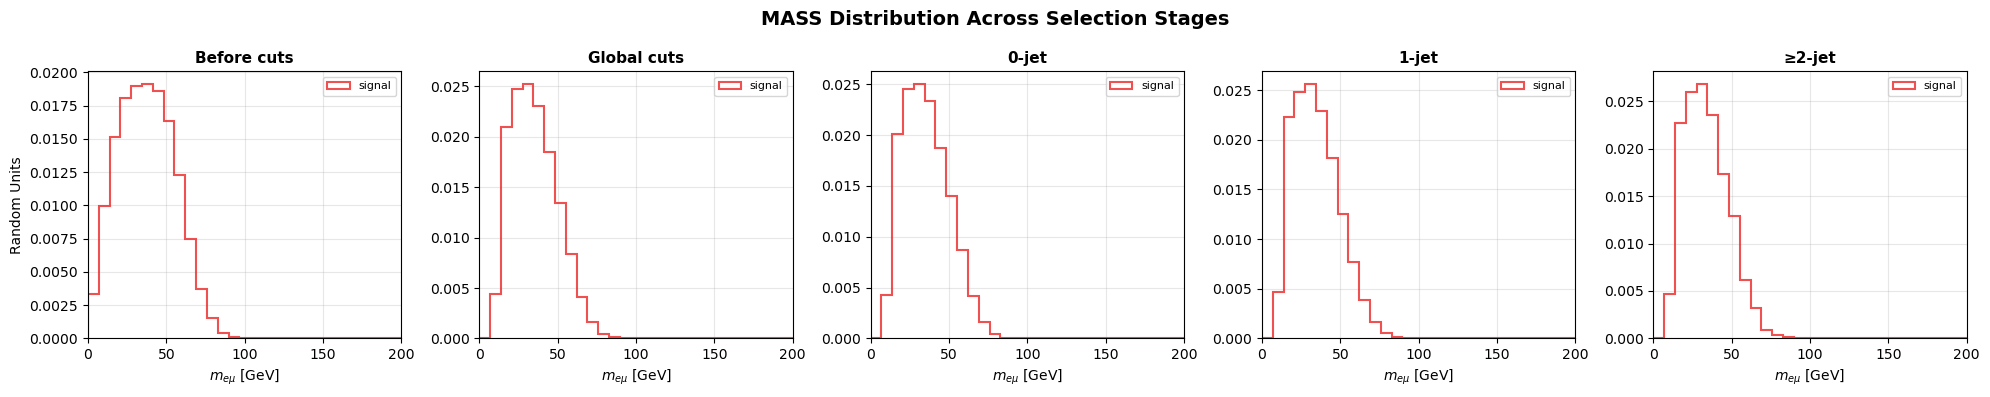


Plotting met...


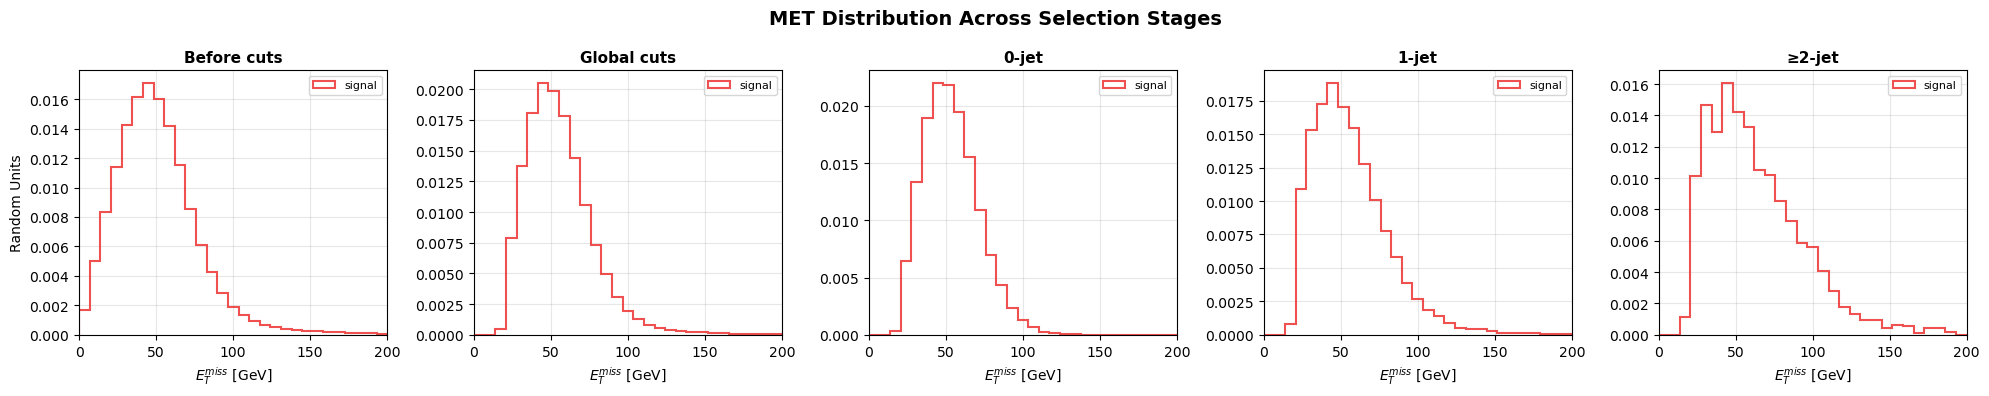


Plotting dphi...


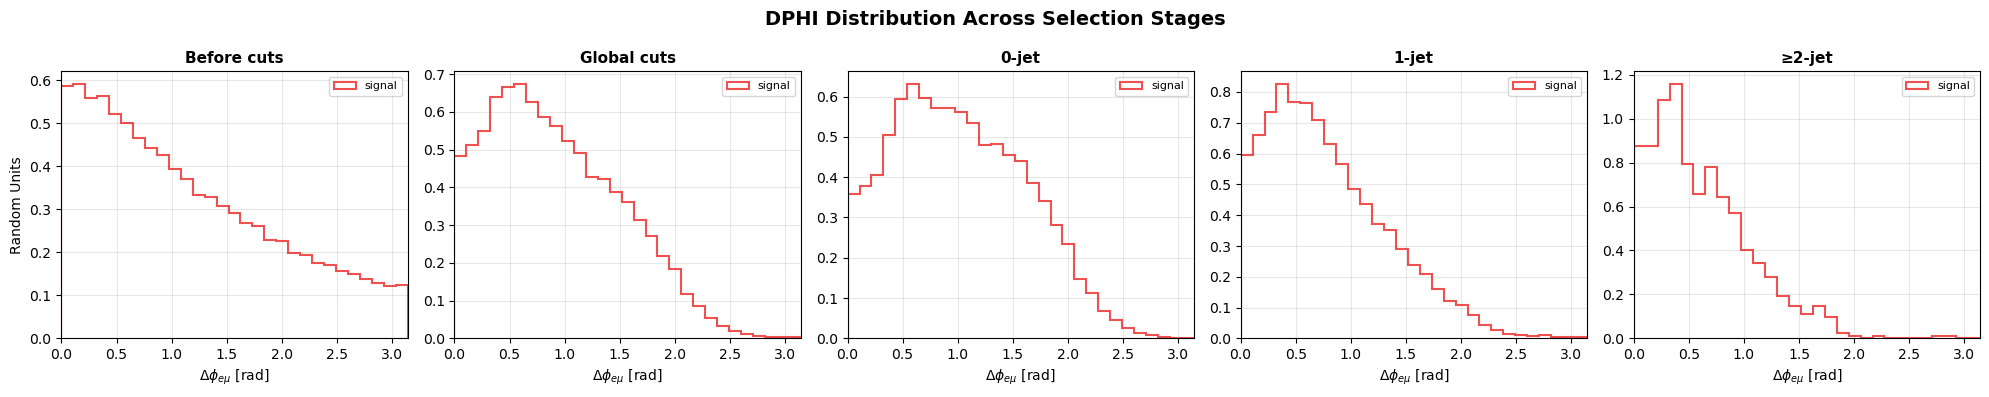


Plotting ptll...


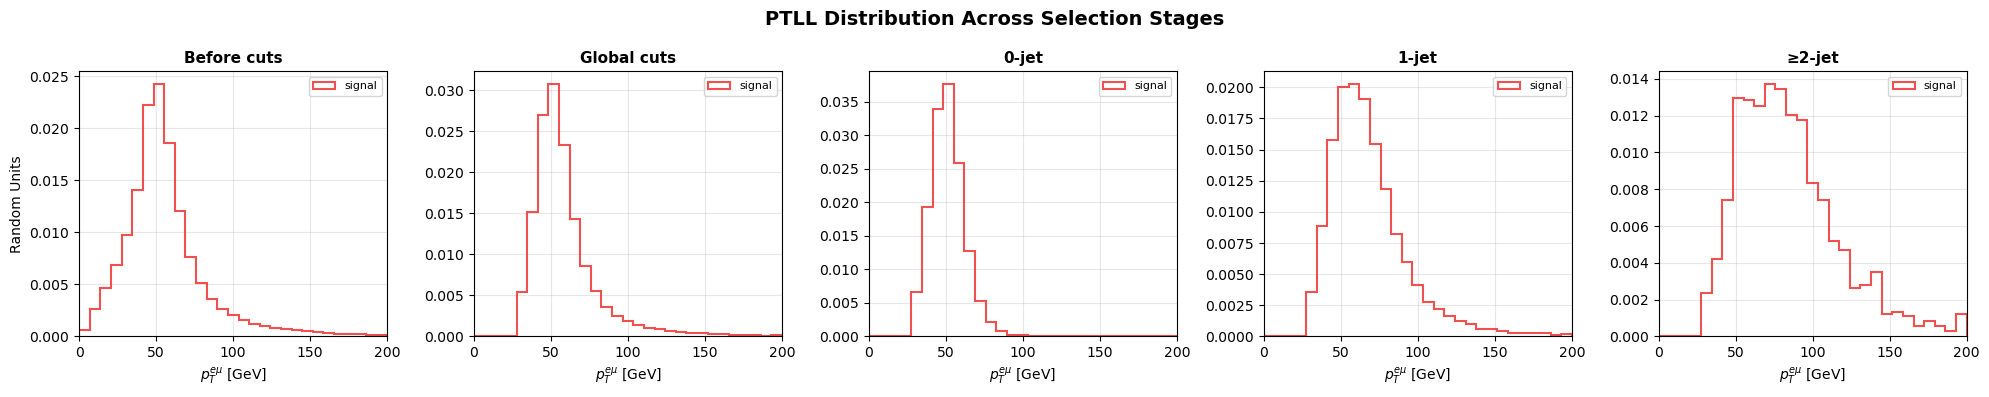


Plotting mt_higgs...


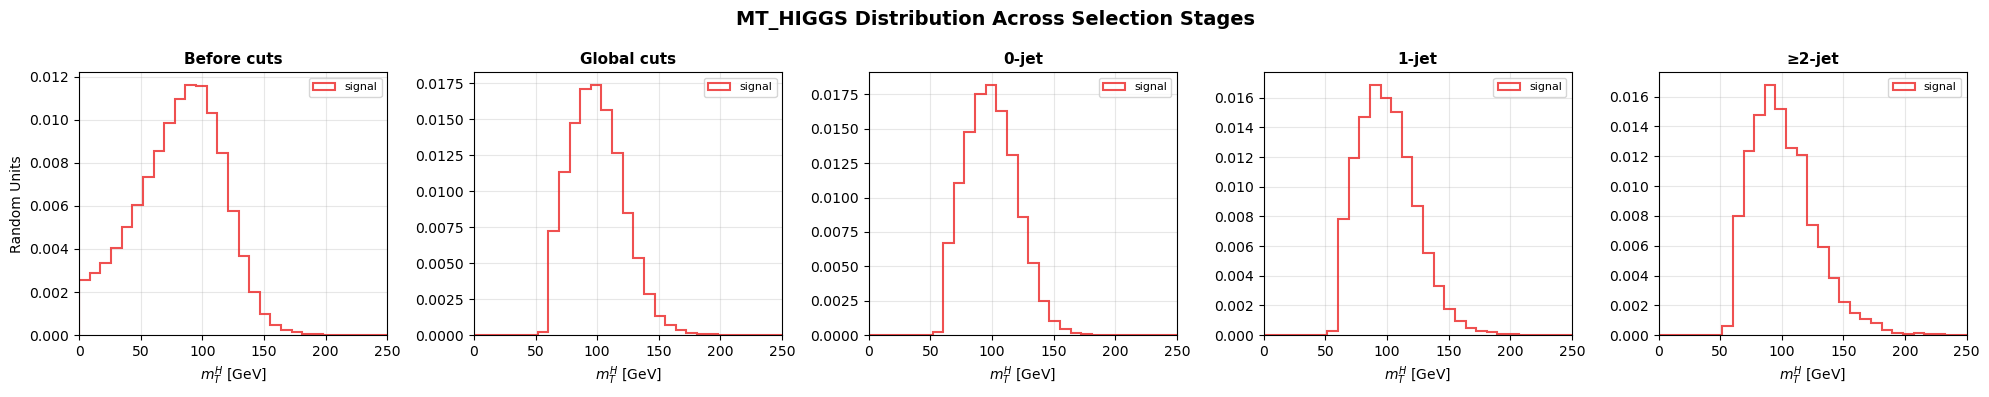


Plotting mt_l2_met...


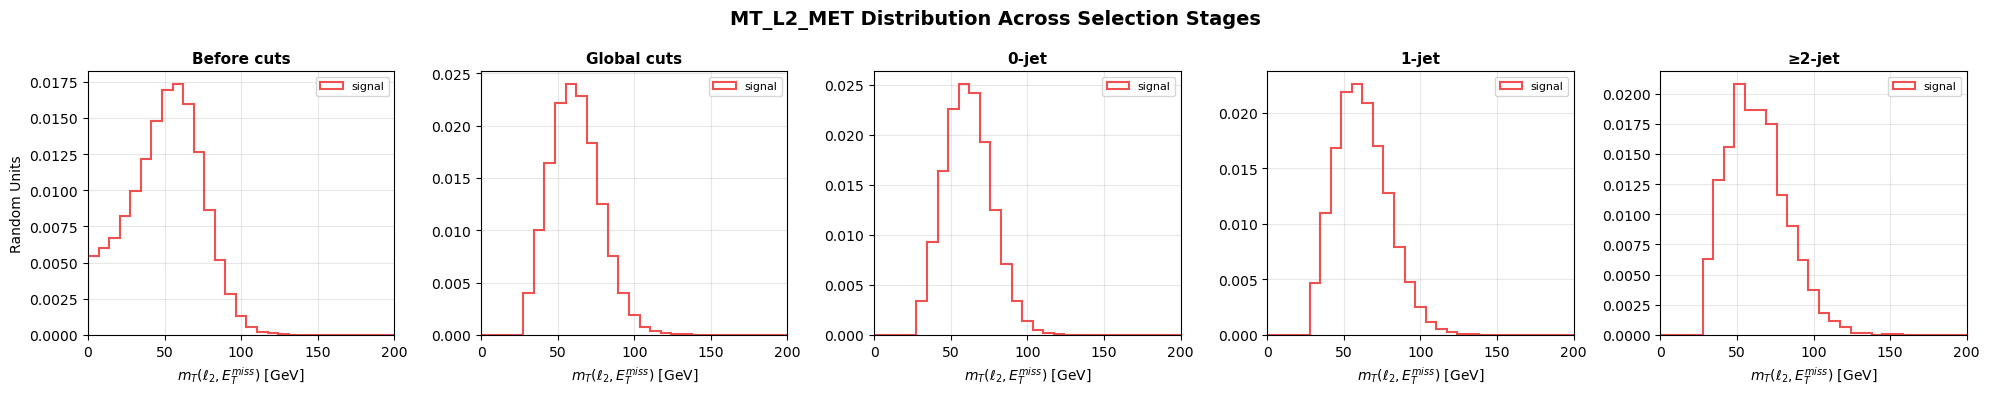


Plotting mjj...


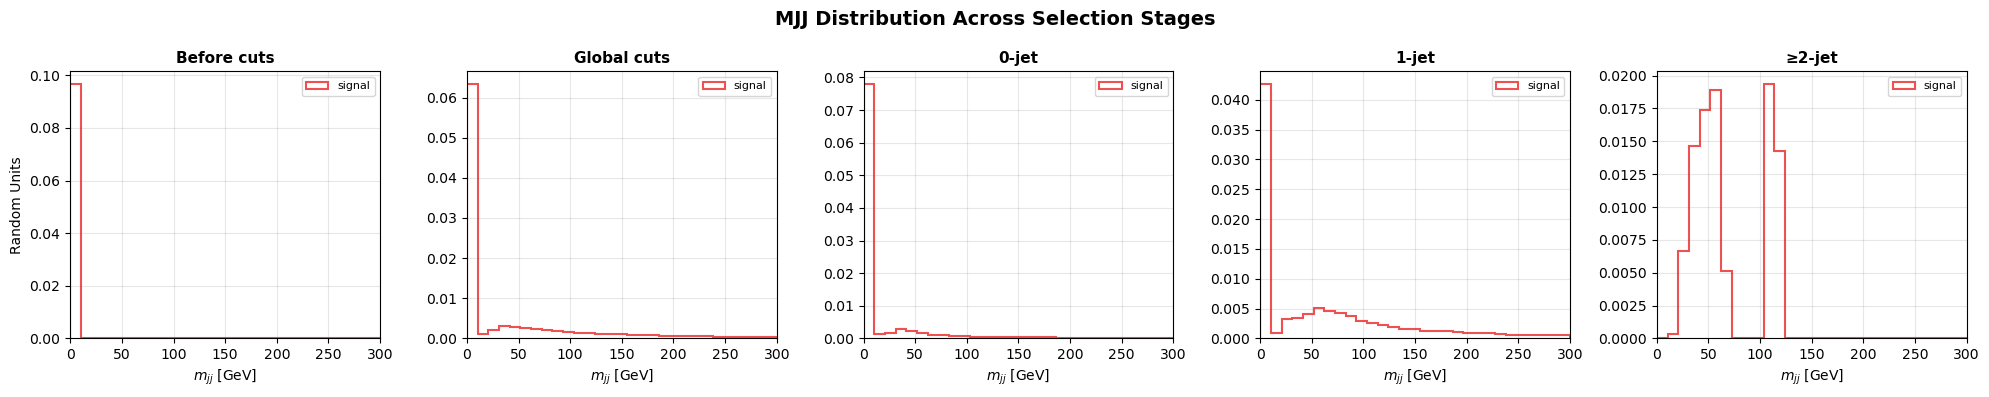

In [45]:
# Plot comparisons for key variables
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

# Plot all variables with signal and backgrounds superimposed
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, stage_data_final)
    plt.show()

In [46]:
def get_backgrounds_and_signal():
    """Get ordered backgrounds and signal for plotting"""
    backgrounds = [key for key, props in SAMPLES.items() 
                  if not props["is_signal"] and props["stack_order"] is not None]
    backgrounds.sort(key=lambda x: SAMPLES[x]["stack_order"])
    
    signal = [key for key, props in SAMPLES.items() if props["is_signal"]]
    
    
    return backgrounds, signal[0] if signal else None

In [47]:
def get_data_sample():
    """Get the data sample name from SAMPLES config"""
    for sample, config in SAMPLES.items():
        if "data" in sample.lower() or "DATA" in sample:
            return sample
    return None

In [48]:
def plot_stage_comparison_stacked(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages with stacked backgrounds and signal, plus signal overlay"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Get backgrounds and signal
    backgrounds, signal = get_backgrounds_and_signal()
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Collect all data (backgrounds for stack)
        stack_data = []
        stack_labels = []
        stack_colors = []
        
        # First add backgrounds
        for bkg in backgrounds:
            if bkg in stage_data_all and stage_data_all[bkg][stage] is not None:
                if variable in stage_data_all[bkg][stage]:
                    data = ak.to_numpy(stage_data_all[bkg][stage][variable])
                    if len(data) > 0:
                        stack_data.append(data)
                        stack_labels.append(bkg)
                        stack_colors.append(SAMPLES[bkg]["color"])
        
        # Get signal data
        sig_data = None
        if signal and signal in stage_data_all and stage_data_all[signal][stage] is not None:
            if variable in stage_data_all[signal][stage]:
                sig_data = ak.to_numpy(stage_data_all[signal][stage][variable])
        
        # Plot stacked histogram (backgrounds only)
        if stack_data:
            ax.hist(stack_data, bins=var_props['bins'], label=stack_labels,
                   color=stack_colors, stacked=True, alpha=1, edgecolor='none')
        
        # Plot signal overlay (outline only)
        if sig_data is not None and len(sig_data) > 0:
            ax.hist(sig_data, bins=var_props['bins'], 
                   histtype='step', linewidth=1.5, 
                   label='Signal (overlay)' if idx == 0 else "", 
                   color=SAMPLES[signal]["color"],
                   linestyle='-')
            
        # Plot data as black dots on top
        data_sample = get_data_sample() 
        if data_sample and data_sample in stage_data_all and stage_data_all[data_sample][stage] is not None:
            if variable in stage_data_all[data_sample][stage]:
                data_points = ak.to_numpy(stage_data_all[data_sample][stage][variable])
                if len(data_points) > 0:
                    # Create histogram for data points to get proper bin heights
                    hist, edges = np.histogram(data_points, bins=var_props['bins'])
                    centers = 0.5 * (edges[:-1] + edges[1:])
                    # Plot only non-zero bins as black dots
                    mask = hist > 0
                    ax.scatter(centers[mask], hist[mask], 
                              c='black', s=10, marker='o', 
                              label='Data' if idx == 0 else "", zorder=10)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)  # minimum y-limit for log scale
        
        if idx == 0:
            ax.set_ylabel('Events', fontsize=10)
            ax.legend(fontsize=8, loc='upper right')
        
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def get_data_sample():
    """Get the data sample name from SAMPLES config"""
    for sample, config in SAMPLES.items():
        if "data" in sample.lower() or "DATA" in sample:
            return sample
    return None


Creating comparison plots...

Plotting mass...


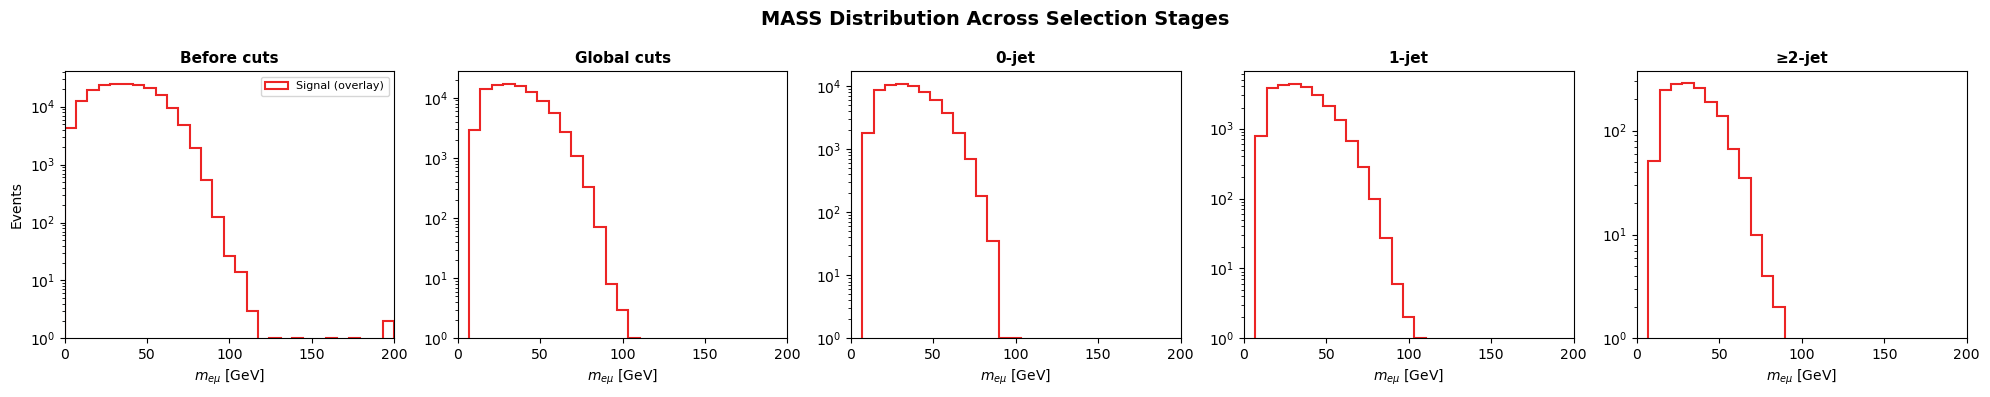


Plotting met...


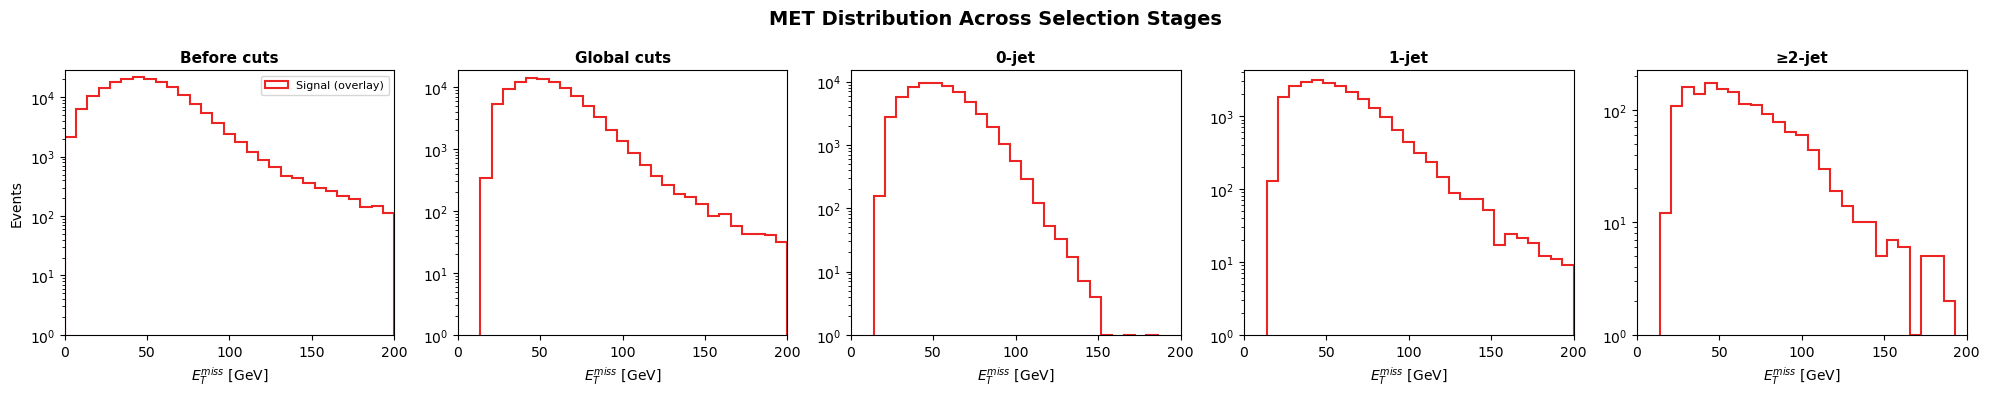


Plotting dphi...


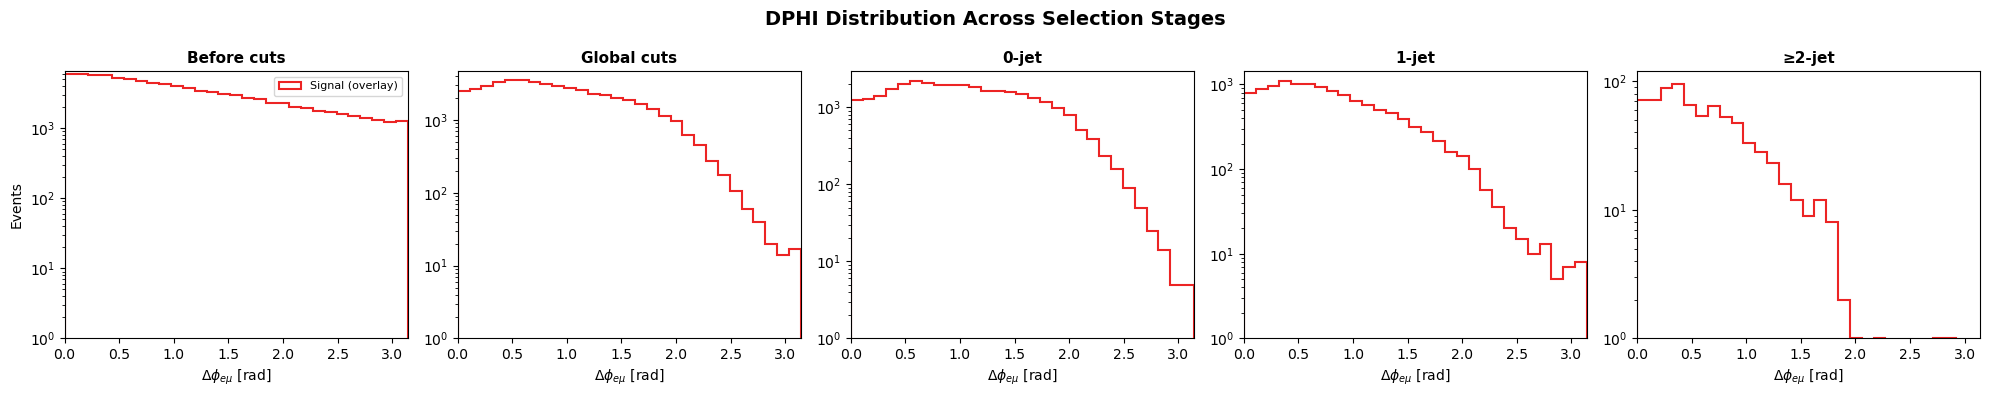


Plotting ptll...


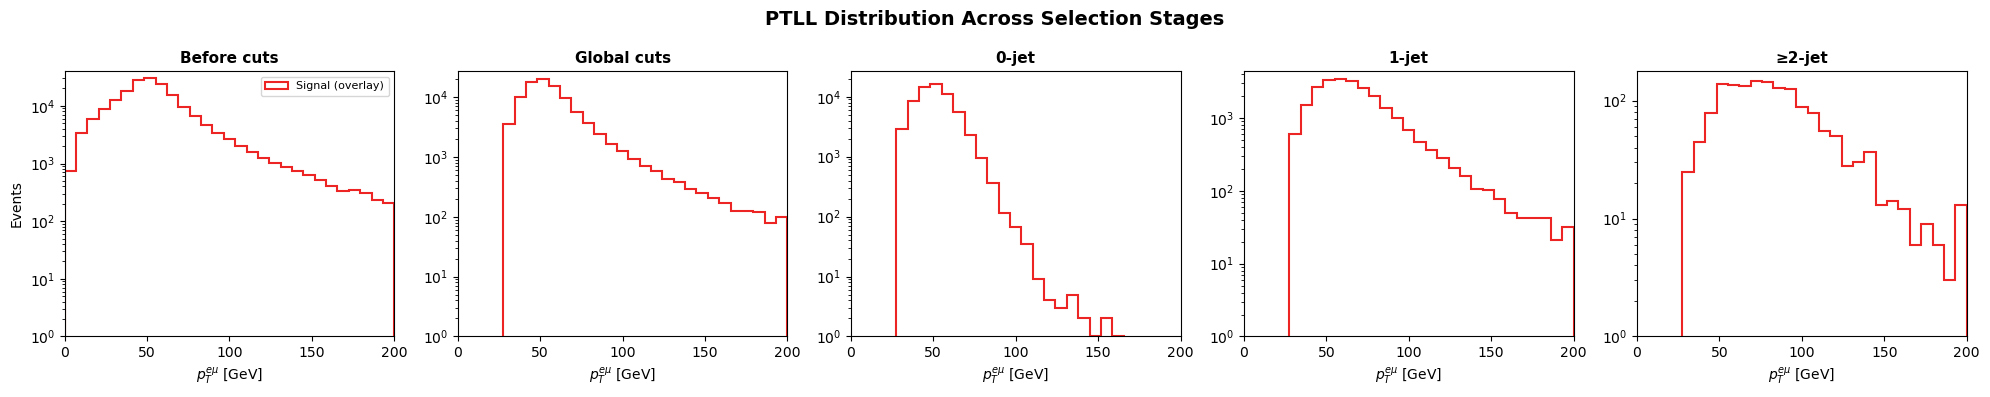


Plotting mt_higgs...


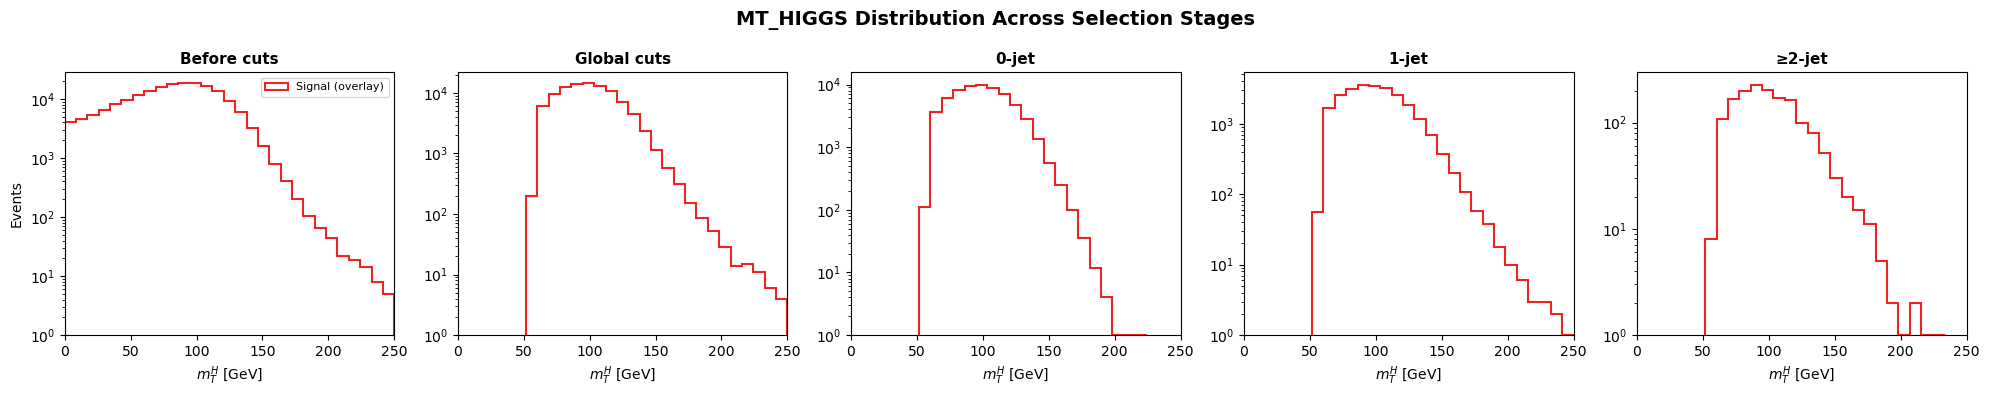


Plotting mt_l2_met...


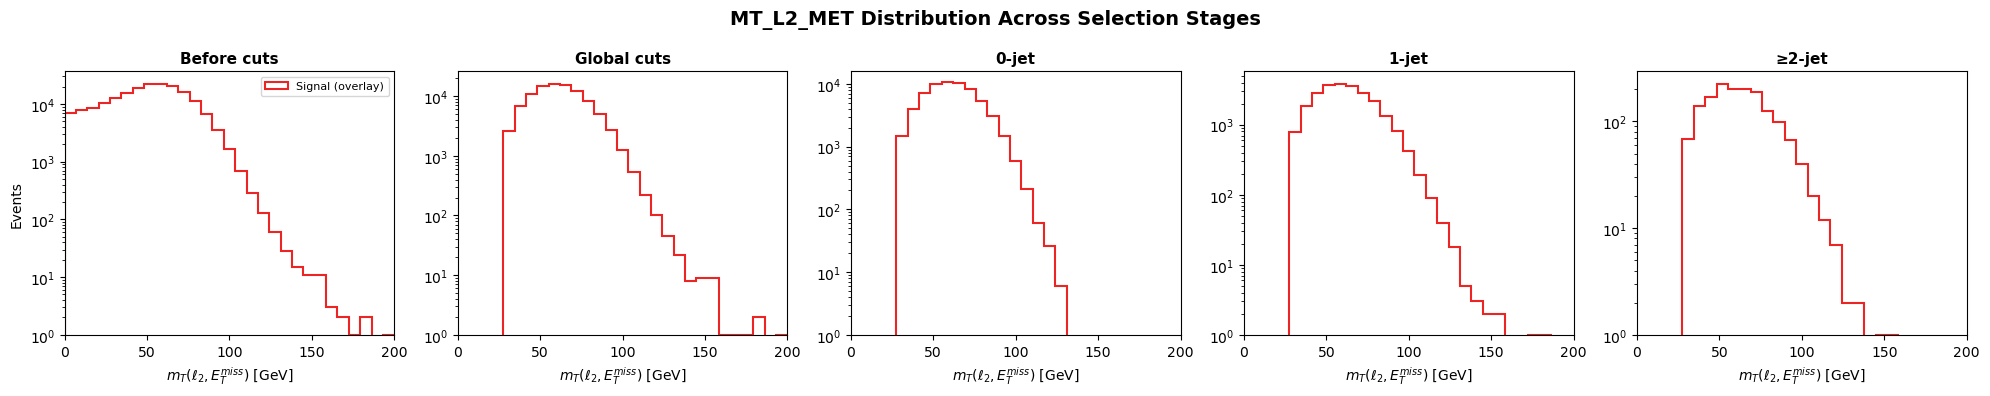


Plotting mjj...


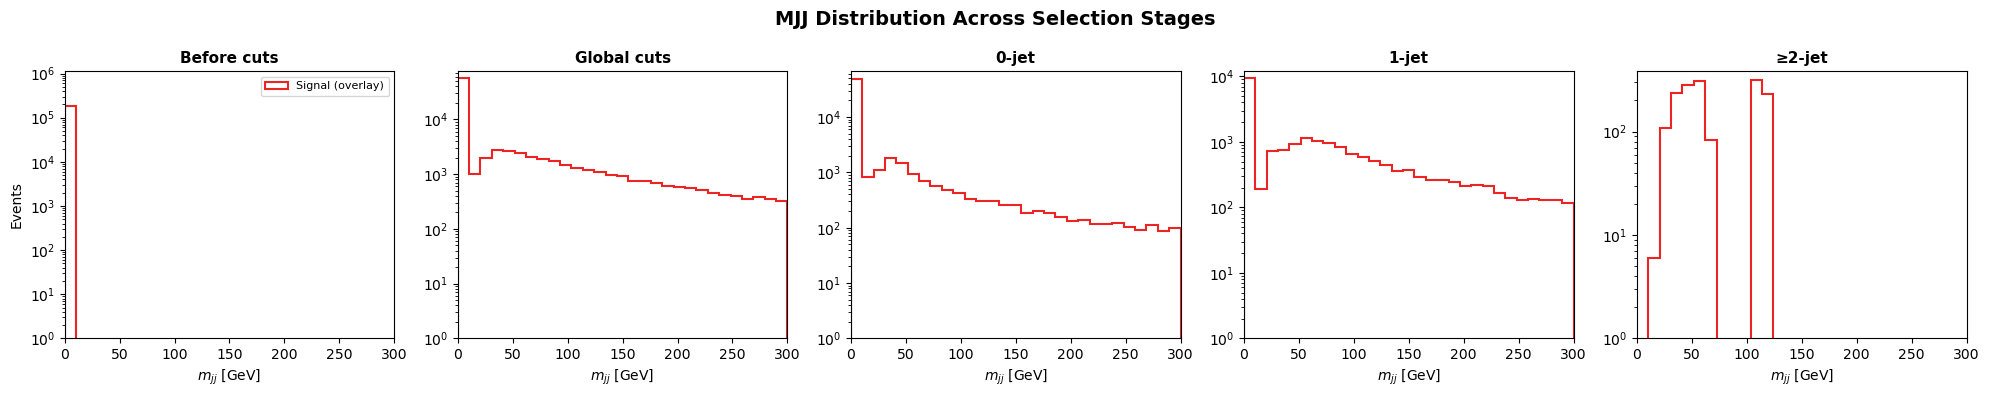

In [49]:
# Plot comparisons with both styles
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    
    # Step histograms (overlaid)
    # fig1 = plot_stage_comparison(var_name, var_props, stage_data_final)
    # plt.show()
    
    # Stacked backgrounds with signal overlay
    fig2 = plot_stage_comparison_stacked(var_name, var_props, stage_data_final)
    plt.show()

In [50]:
def plot_sr_cr_stacked(variable, var_props, stage_data_all):
    """Create stacked plots for SR and CR regions across jet categories"""
    
    # Define regions and categories
    sr_categories = ['SR_0jet', 'SR_1jet', 'SR_2jet']
    cr_top_categories = ['CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet']
    cr_tau_categories = ['CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']
    
    category_labels = ['0-jet', '1-jet', '2-jet']
    
    # Create subplot grid: 3 rows (SR, CR_top, CR_tau) x 3 cols (0j, 1j, 2j)
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    
    # Get backgrounds and signal
    backgrounds, signal = get_backgrounds_and_signal()
    data_sample = get_data_sample()
    
    region_groups = [
        (sr_categories, 'Signal Regions', 0),
        (cr_top_categories, 'Top Control Regions', 1),
        (cr_tau_categories, 'ττ Control Regions', 2)
    ]
    
    for categories, region_name, row_idx in region_groups:
        for col_idx, (category, jet_label) in enumerate(zip(categories, category_labels)):
            ax = axes[row_idx, col_idx]
            
            # Collect background data for stacking
            stack_data = []
            stack_labels = []
            stack_colors = []
            
            # Add backgrounds
            for bkg in backgrounds:
                if (bkg in stage_data_all and 
                    stage_data_all[bkg].get(category) and
                    variable in stage_data_all[bkg][category]):
                    
                    data = ak.to_numpy(stage_data_all[bkg][category][variable])
                    if len(data) > 0:
                        stack_data.append(data)
                        stack_labels.append(bkg)
                        stack_colors.append(SAMPLES[bkg]["color"])
            
            # Get signal data
            sig_data = None
            if (signal and signal in stage_data_all and 
                stage_data_all[signal].get(category) and
                variable in stage_data_all[signal][category]):
                sig_data = ak.to_numpy(stage_data_all[signal][category][variable])
            
            # Plot stacked backgrounds
            if stack_data:
                ax.hist(stack_data, bins=var_props['bins'], 
                       label=stack_labels if row_idx == 0 and col_idx == 0 else None,
                       color=stack_colors, stacked=True, alpha=0.8, edgecolor='none')
            
            # Plot signal overlay
            if sig_data is not None and len(sig_data) > 0:
                ax.hist(sig_data, bins=var_props['bins'], 
                       histtype='step', linewidth=2, 
                       label='Signal' if row_idx == 0 and col_idx == 0 else None,
                       color=SAMPLES[signal]["color"], linestyle='-')
            
            # Plot data as black dots
            if (data_sample and data_sample in stage_data_all and 
                stage_data_all[data_sample].get(category) and
                variable in stage_data_all[data_sample][category]):
                
                data_points = ak.to_numpy(stage_data_all[data_sample][category][variable])
                if len(data_points) > 0:
                    hist, edges = np.histogram(data_points, bins=var_props['bins'])
                    centers = 0.5 * (edges[:-1] + edges[1:])
                    mask = hist > 0
                    ax.scatter(centers[mask], hist[mask], 
                              c='black', s=15, marker='o',
                              label='Data' if row_idx == 0 and col_idx == 0 else None,
                              zorder=10)
            
            # Formatting
            ax.set_xlim(var_props['xlim'])
            ax.set_yscale('log')
            ax.set_ylim(bottom=0.1)
            
            # Labels and titles
            if row_idx == 2:  # Bottom row
                ax.set_xlabel(var_props['xlabel'], fontsize=10)
            if col_idx == 0:  # Left column
                ax.set_ylabel('Events', fontsize=10)
            
            # Subplot title
            ax.set_title(f'{region_name.split()[0]} {jet_label}', fontsize=11, fontweight='bold')
            
            # Legend only on top-left subplot
            if row_idx == 0 and col_idx == 0:
                ax.legend(fontsize=8, loc='upper right')
            
            ax.grid(True, alpha=0.3)
    
    # Overall title
    plt.suptitle(f'{variable.upper()} Distribution: Signal and Control Regions', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Add explicit plt.show() and return figure
    plt.show()
    return fig



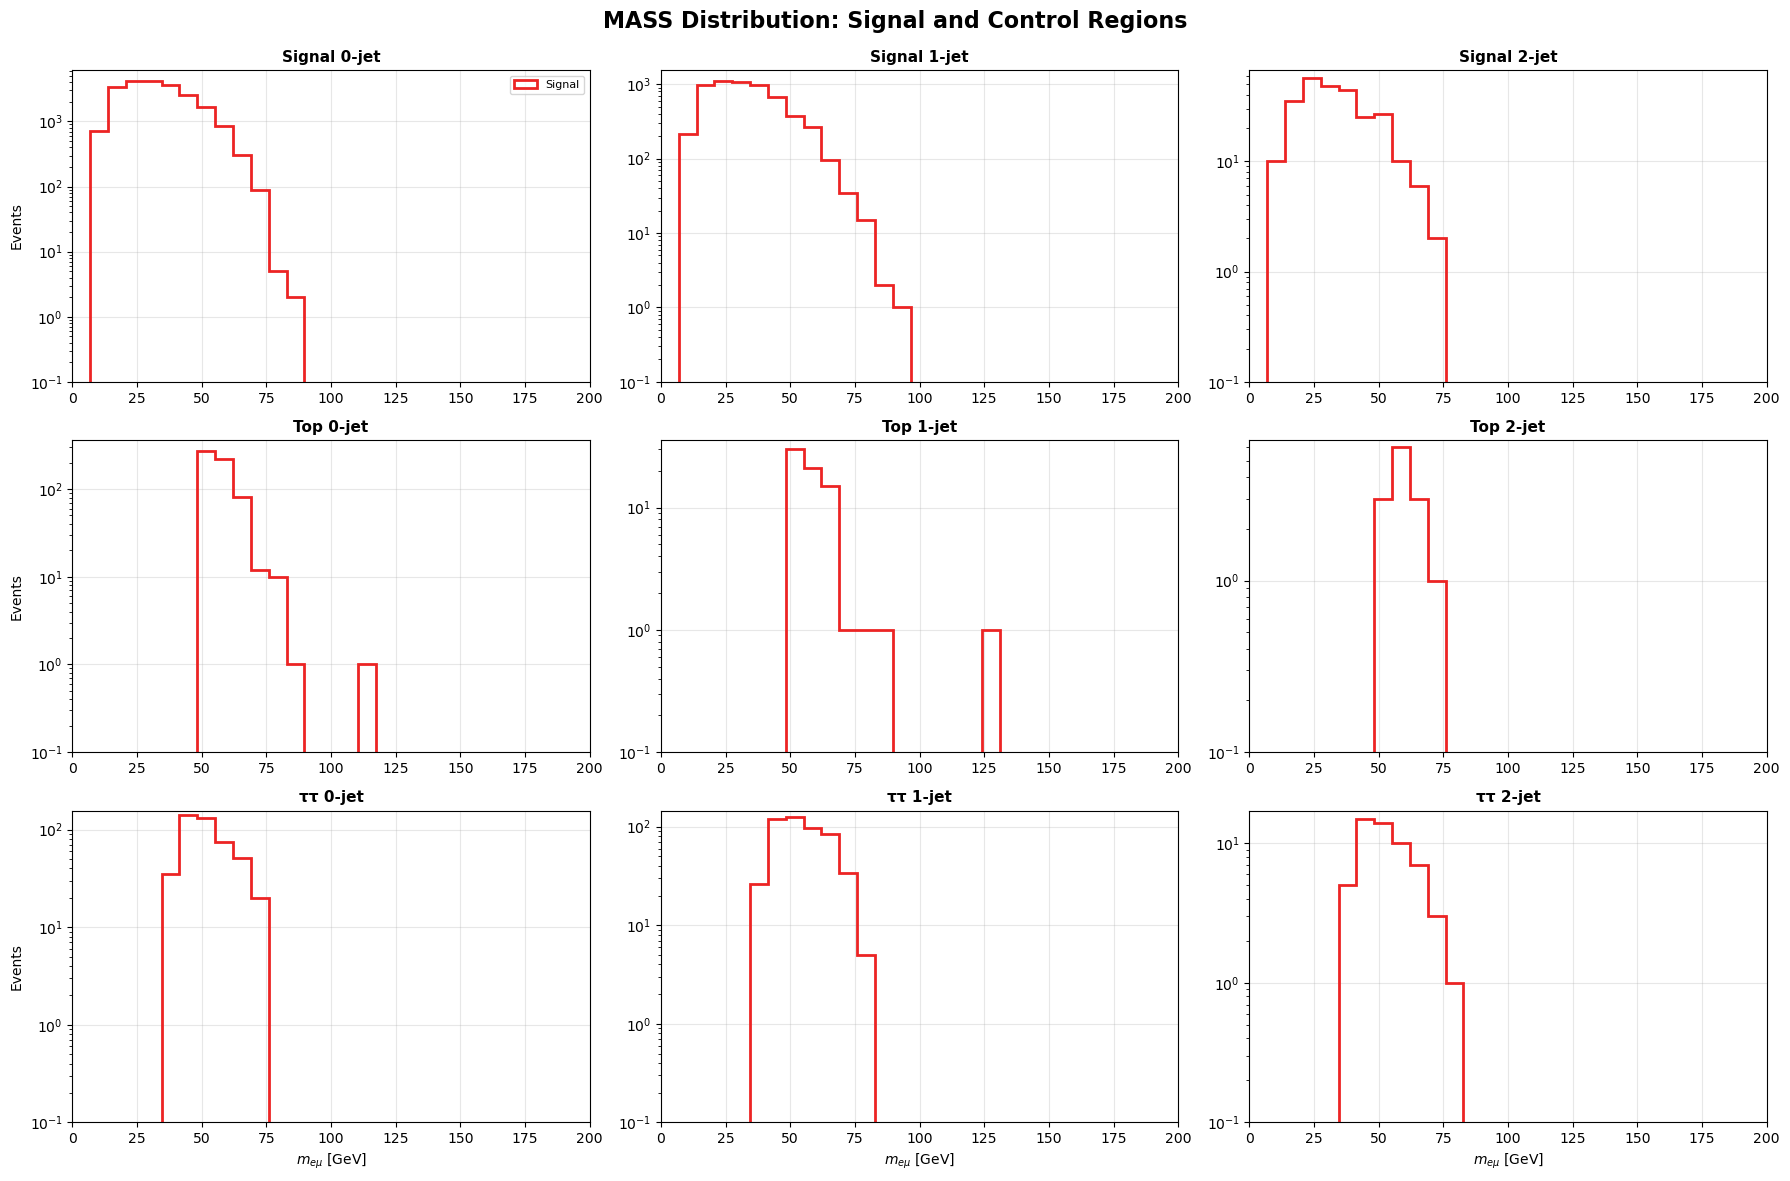

In [51]:
# Usage - call it in a separate cell or with proper control
if __name__ == "__main__":
    fig = plot_sr_cr_stacked('mass', variables_to_plot['mass'], stage_data_final)